# Mushroom Edibility Classification Using Machine Learning

In [22]:
pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
    --------------------------------------- 1.0/72.0 MB 7.1 MB/s eta 0:00:10
   -- ------------------------------------- 4.7/72.0 MB 13.3 MB/s eta 0:00:06
   ----- ---------------------------------- 9.2/72.0 MB 19.2 MB/s eta 0:00:04
   --------- ------------------------------ 17.3/72.0 MB 22.4 MB/s eta 0:00:03
   ------------- -------------------------- 23.6/72.0 MB 24.3 MB/s eta 0:00:02
   --------------- ------------------------ 28.0/72.0 MB 23.4 MB/s eta 0:00:02
   ------------------ --------------------- 32.8/72.0 MB 23.4 MB/s eta 0:00:02
   --------------------- ------------------ 38.3/72.0 MB 23.7 MB/s eta 0:00:02
   ------------------------ --------------- 43.3/72.0 MB 23.6 MB/s eta 0:00:02
   -------------------------- ------------- 48.2/72.0 MB 23.7 MB/s eta 0:00:02
   ----------------------------- ---------- 53.2/72.0 MB 23.7 MB/s eta 0:0

# Imports

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)
import joblib

# Data Loading and EDA

In [2]:
df=pd.read_csv("secondary_data_shuffled.csv", sep =";")
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,1.72,x,s,y,f,d,NaN,w,7.01,...,NaN,t,y,NaN,NaN,f,f,NaN,h,u
1,e,9.59,f,e,b,f,NaN,c,b,4.73,...,NaN,NaN,w,NaN,NaN,t,f,NaN,d,a
2,p,0.86,x,g,p,f,a,NaN,p,4.25,...,NaN,s,k,NaN,NaN,f,f,NaN,d,s
3,p,4.32,x,NaN,e,f,x,NaN,w,4.91,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,2.80,x,s,w,f,d,d,w,3.13,...,NaN,NaN,w,NaN,NaN,f,f,NaN,m,a


In [3]:
df["class"].value_counts()

class
p    33888
e    27181
Name: count, dtype: int64

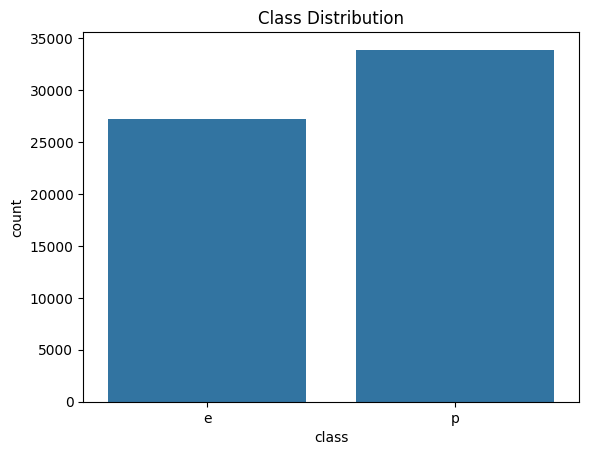

In [4]:
sns.countplot(x='class', data=df)
plt.title("Class Distribution")
plt.show()


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

In [6]:
df.describe()

,cap-diameter,stem-height,stem-width
count,61069.000000,61069.000000,61069.000000
mean,6.733854,6.581538,12.149410
std,5.264845,3.370017,10.035955
min,0.380000,0.000000,0.000000
25%,3.480000,4.640000,5.210000
50%,5.860000,5.950000,10.190000
75%,8.540000,7.740000,16.570000
max,62.340000,33.920000,103.910000


In [7]:
df.shape

(61069, 21)

In [8]:
missing_percent = df.isnull().mean().sort_values(ascending=False) * 100
missing_percent


veil-type               94.797688
spore-print-color       89.595376
veil-color              87.861272
stem-root               84.393064
stem-surface            62.427746
gill-spacing            41.040462
cap-surface             23.121387
gill-attachment         16.184971
ring-type                4.046243
cap-color                0.000000
cap-shape                0.000000
cap-diameter             0.000000
class                    0.000000
stem-height              0.000000
stem-width               0.000000
does-bruise-or-bleed     0.000000
gill-color               0.000000
has-ring                 0.000000
stem-color               0.000000
habitat                  0.000000
season                   0.000000
dtype: float64

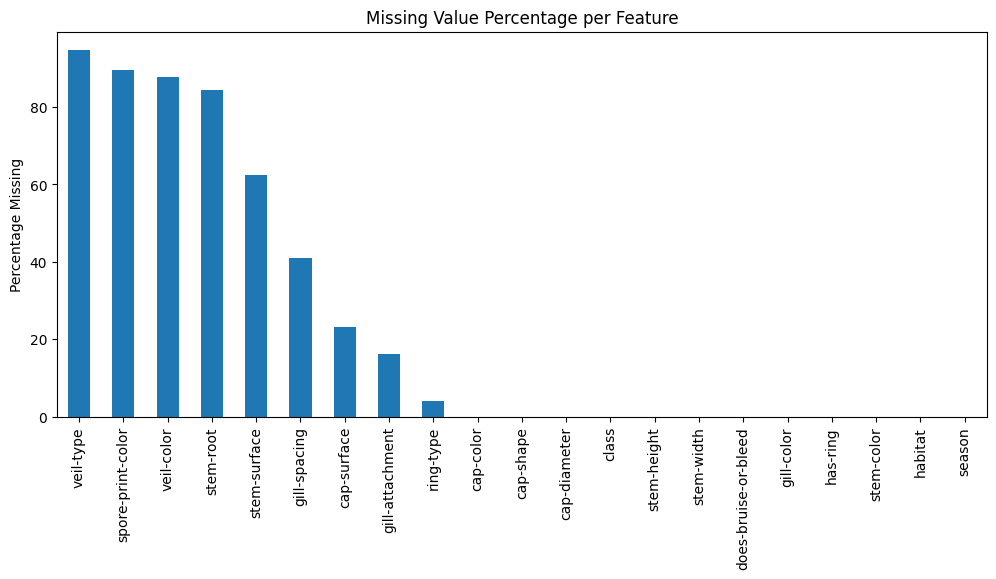

In [9]:
missing_percent.plot(kind='bar', figsize=(12,5))
plt.ylabel("Percentage Missing")
plt.title("Missing Value Percentage per Feature")
plt.show()


# Mapping target to 0 and 1

In [10]:
X = df.drop(columns=['class'])
y = df['class'].map({'e': 0, 'p': 1})

In [11]:
# Numeric features
numeric_features = ['cap-diameter', 'stem-height', 'stem-width']

# Categorical features after dropping heavy-missing
categorical_features = [
    'cap-shape', 'cap-color', 'does-bruise-or-bleed', 
    'gill-attachment', 'gill-spacing', 'gill-color',
    'stem-color', 'has-ring', 'ring-type', 'habitat', 'season'
]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

Numeric features: ['cap-diameter', 'stem-height', 'stem-width']
Categorical features: ['cap-shape', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season']


# Helper function for model evaluation

In [12]:
def evaluate_model(model, X, y, title):
    # Predictions
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]  # probability for positive class

    # Classification report
    print(title)
    print(classification_report(y, y_pred))
    print("ROC-AUC:", roc_auc_score(y, y_prob))

    # Confusion matrix
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"{title} - Confusion Matrix")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y, y_prob)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y, y_prob):.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} - ROC Curve")
    plt.legend()
    plt.show()

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y, y_prob)
    ap_score = average_precision_score(y, y_prob)
    plt.plot(recall, precision, label=f"AP = {ap_score:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title} - Precision-Recall Curve")
    plt.legend()
    plt.show()


# Preprocessing

In [13]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


# Data Splitting

In [14]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

X_train_final = pd.concat([X_train, X_val], axis=0)
y_train_final = pd.concat([y_train, y_val], axis=0)

print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))

class
1    0.554903
0    0.445097
Name: proportion, dtype: float64
class
1    0.554961
0    0.445039
Name: proportion, dtype: float64
class
1    0.554913
0    0.445087
Name: proportion, dtype: float64


# Logistic Regression Training

In [15]:
logreg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1,
        solver="saga"
    ))
])

logreg_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cap-diameter',
                                                   'stem-height',
                                                   'stem-width']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['cap-shape', 'cap-color',
                                                   'does-bruise-or-bleed',
                                                   'gill-attachment',
                                                   'gill-spacing', 'gill-color',
                                                   'stem-color', 'has-ring',
                                                   'ring-type', 'habitat',
                                                   'season'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1, solver='saga'))])

Logistic Regression (Initial)
              precision    recall  f1-score   support

           0       0.72      0.82      0.76      4077
           1       0.83      0.74      0.79      5083

    accuracy                           0.77      9160
   macro avg       0.78      0.78      0.77      9160
weighted avg       0.78      0.77      0.78      9160

ROC-AUC: 0.8383728319366266


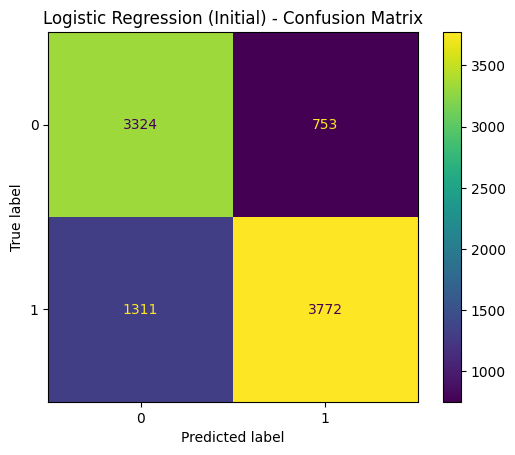

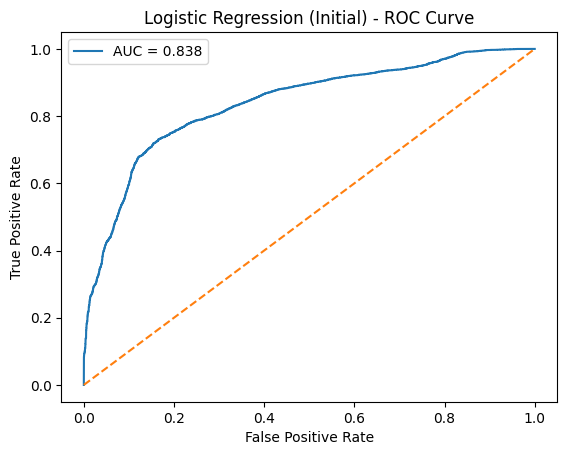

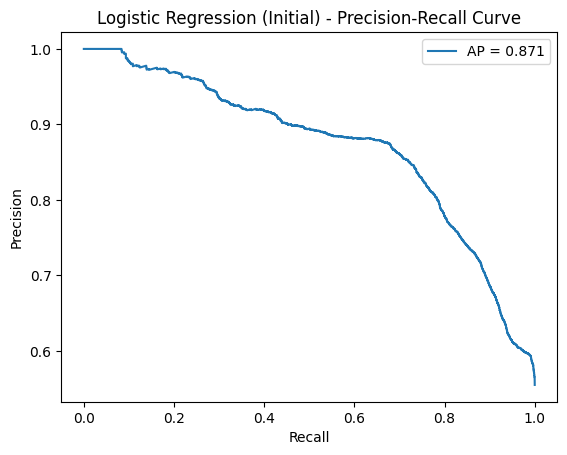

In [16]:
evaluate_model(
    logreg_model,
    X_val,
    y_val,
    "Logistic Regression (Initial)"
)

# Finding best parameters

In [18]:
lr_param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__penalty": ['l2'],            
    "classifier__solver": ['lbfgs']
}

grid_lr = GridSearchCV(
    logreg_model,
    lr_param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)
print("Best Logistic Regression Params:")
print(grid_lr.best_params_)

Best Logistic Regression Params:
{'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Logistic Regression (Validation)
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      4077
           1       0.83      0.75      0.79      5083

    accuracy                           0.78      9160
   macro avg       0.78      0.78      0.78      9160
weighted avg       0.78      0.78      0.78      9160

ROC-AUC: 0.8303565280411878


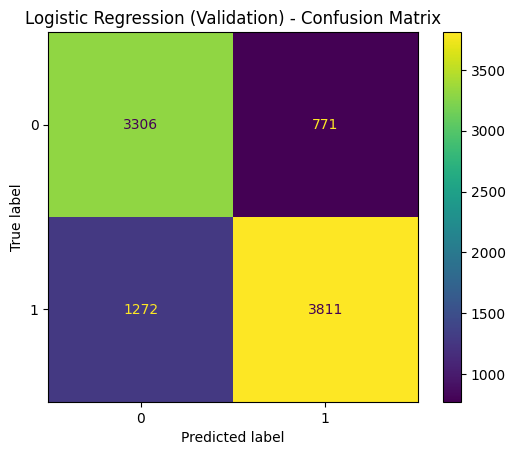

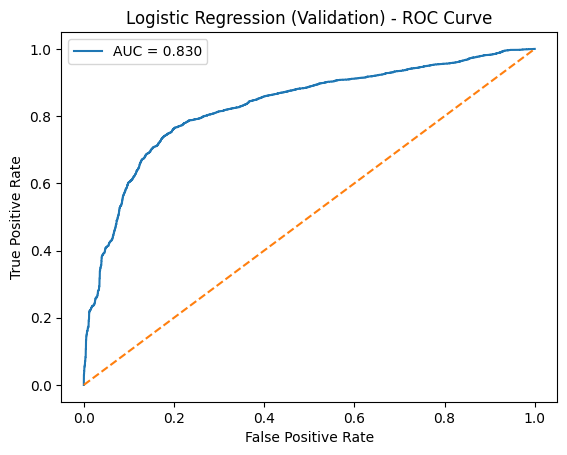

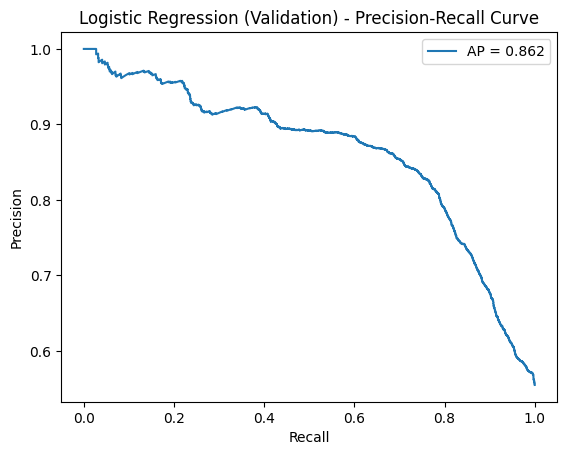

In [20]:
evaluate_model(
    grid_lr.best_estimator_,
    X_val,
    y_val,
    "Logistic Regression (Validation)"
)

In [21]:
final_lr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        C=0.01,
        penalty="l2",
        max_iter=1000,
        random_state=42
    ))
])

final_lr_pipeline.fit(X_train_final, y_train_final)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cap-diameter',
                                                   'stem-height',
                                                   'stem-width']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['cap-shape', 'cap-color',
                                                   'does-bruise-or-bleed',
                                                   'gill-attachment',
                                                   'gill-spacing', 'gill-color',
                                                   'stem-color', 'has-ring',
                                                   'ring-type', 'habitat',
                                                   'season'])])),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=42))])

In [22]:
lr_test_pred = final_lr_pipeline.predict(X_test)
lr_test_prob = final_lr_pipeline.predict_proba(X_test)[:, 1]

print("Logistic Regression - Final Test")
print(classification_report(y_test, lr_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, lr_test_prob))

Logistic Regression - Final Test
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      4077
           1       0.78      0.80      0.79      5084

    accuracy                           0.76      9161
   macro avg       0.76      0.76      0.76      9161
weighted avg       0.76      0.76      0.76      9161

ROC-AUC: 0.8224948652676729


In [21]:
joblib.dump(final_lr_pipeline, "final_logistic_model.pkl")

['final_logistic_model.pkl']

Logistic Regression (Test)
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      4077
           1       0.78      0.80      0.79      5084

    accuracy                           0.76      9161
   macro avg       0.76      0.76      0.76      9161
weighted avg       0.76      0.76      0.76      9161

ROC-AUC: 0.8224948652676729


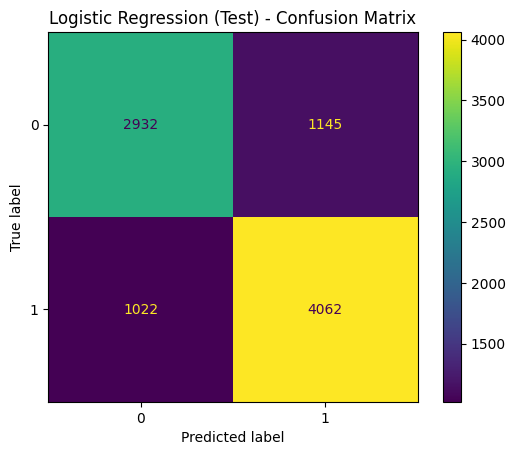

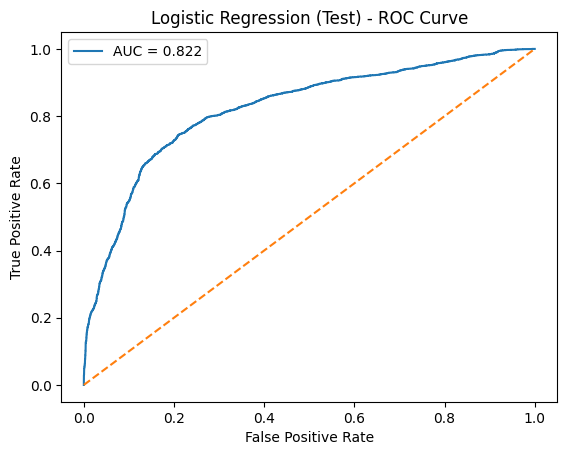

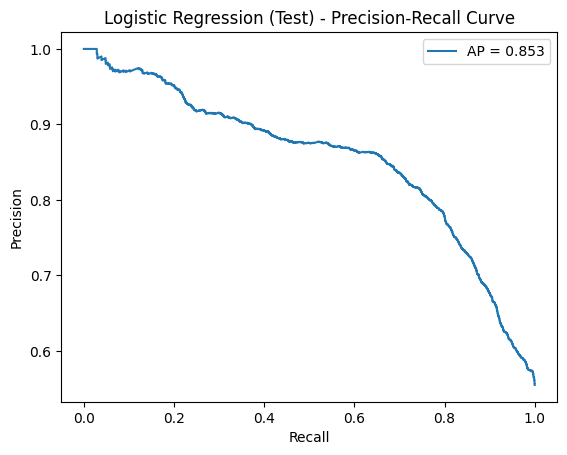

In [68]:
evaluate_model(
    final_lr_pipeline,
    X_test,
    y_test,
    "Logistic Regression (Test)"
)

# Random Forest Training

In [35]:
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        max_depth=10,
        class_weight="balanced"
    ))
])

rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cap-diameter',
                                                   'stem-height',
                                                   'stem-width']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['cap-shape', 'cap-color',
                                                   'does-bruise-or-bleed',
                                                   'gill-attachment',
                                                   'gill-spacing', 'gill-color',
                                                   'stem-color', 'has-ring',
                                                   'ring-type', 'habitat',
                                                   'season'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        n_jobs=-1, random_state=42))])

Random Forest (Initial)
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4077
           1       0.99      0.96      0.97      5083

    accuracy                           0.97      9160
   macro avg       0.97      0.97      0.97      9160
weighted avg       0.97      0.97      0.97      9160

ROC-AUC: 0.9978378538531653


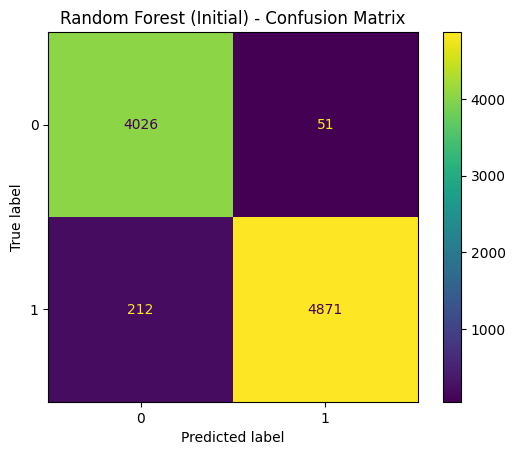

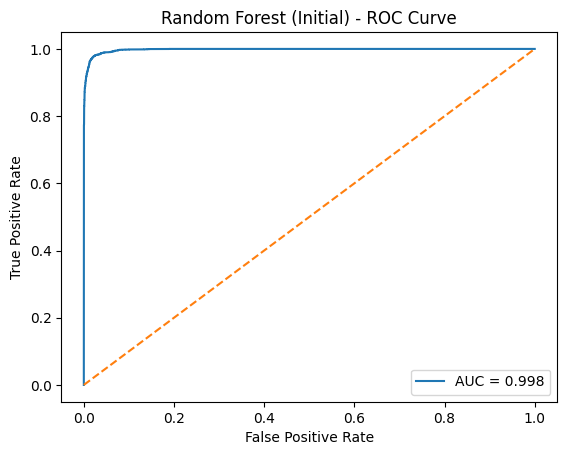

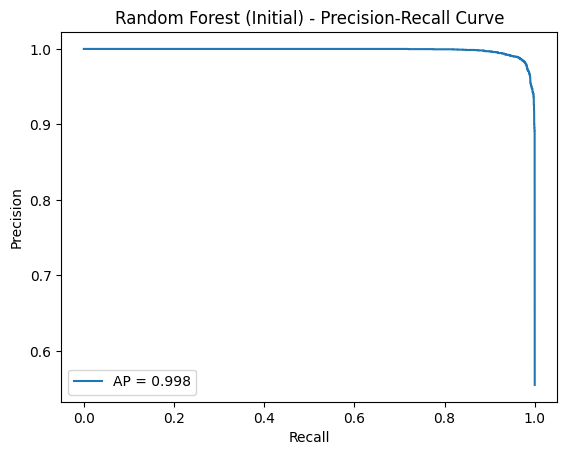

In [36]:
evaluate_model(
    rf_model,
    X_val,
    y_val,
    "Random Forest (Initial)"
)

# Finding best parameters

In [37]:
rf_param_grid = {
    "classifier__n_estimators": [100, 200,300],
    "classifier__max_depth": [None, 2, 5, 10, 20],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf":[2,3]
}

grid_rf = GridSearchCV(
    rf_model,
    rf_param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Best RF Params:", grid_rf.best_params_)

Best RF Params: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}


Random Forest (Validation)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4077
           1       1.00      1.00      1.00      5083

    accuracy                           1.00      9160
   macro avg       1.00      1.00      1.00      9160
weighted avg       1.00      1.00      1.00      9160

ROC-AUC: 0.999999855236047


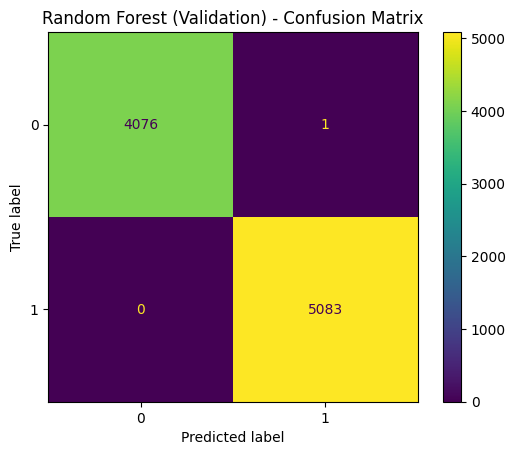

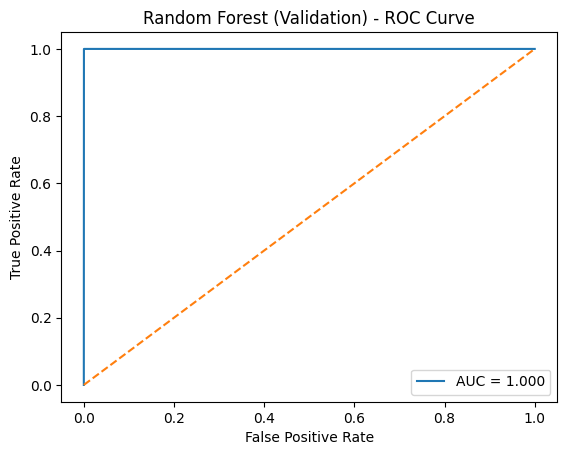

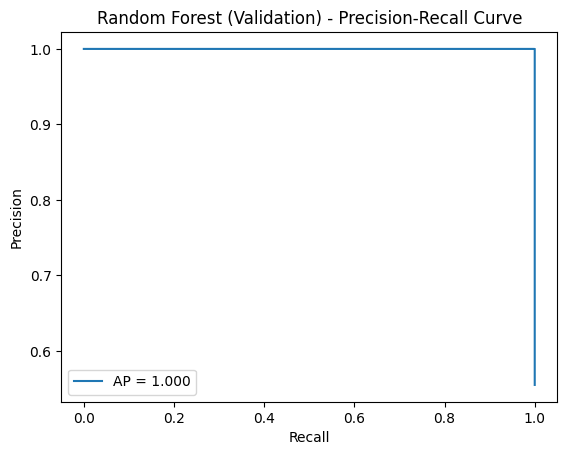

In [38]:
evaluate_model(
    grid_rf.best_estimator_,
    X_val,
    y_val,
    "Random Forest (Validation)"
)

In [42]:
final_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        max_depth= None,
        min_samples_split=5,
        min_samples_leaf= 2,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

final_rf.fit(X_train_final, y_train_final)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cap-diameter',
                                                   'stem-height',
                                                   'stem-width']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['cap-shape', 'cap-color',
                                                   'does-bruise-or-bleed',
                                                   'gill-attachment',
                                                   'gill-spacing', 'gill-color',
                                                   'stem-color', 'has-ring',
                                                   'ring-type', 'habitat',
                                                   'season'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=2, min_samples_split=5,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))])

Random Forest (Test)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4077
           1       1.00      1.00      1.00      5084

    accuracy                           1.00      9161
   macro avg       1.00      1.00      1.00      9161
weighted avg       1.00      1.00      1.00      9161

ROC-AUC: 1.0


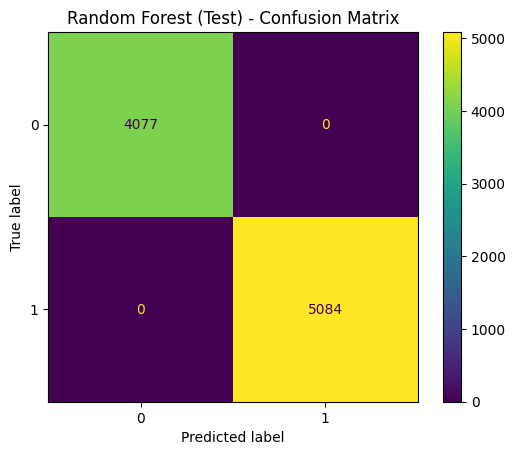

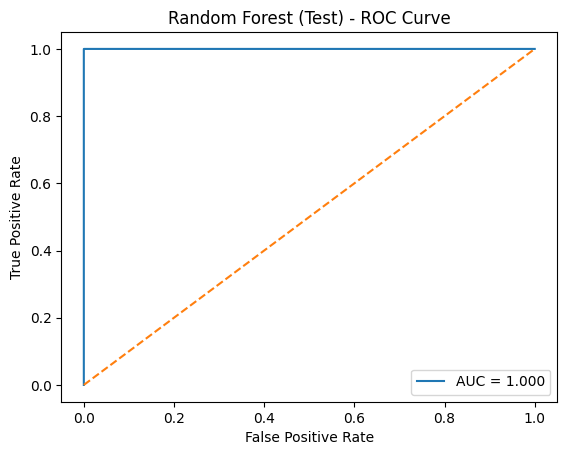

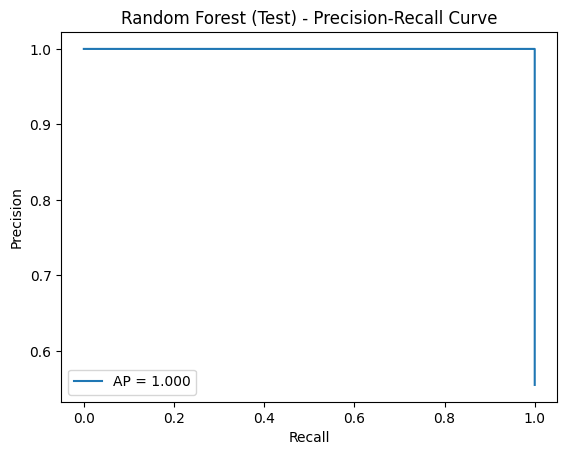

In [43]:
evaluate_model(
    final_rf,
    X_test,
    y_test,
    "Random Forest (Test)"
)


In [46]:
joblib.dump(final_rf, "best_mushroom_random_forest_model.pkl")

['best_mushroom_random_forest_model.pkl']

# XgBoost model training

In [47]:
xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        eval_metric="logloss",
        random_state=42
    ))
])

xgb_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cap-diameter',
                                                   'stem-height',
                                                   'stem-width']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

XGBoost (Initial)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4077
           1       1.00      1.00      1.00      5083

    accuracy                           1.00      9160
   macro avg       1.00      1.00      1.00      9160
weighted avg       1.00      1.00      1.00      9160

ROC-AUC: 0.999999613962792


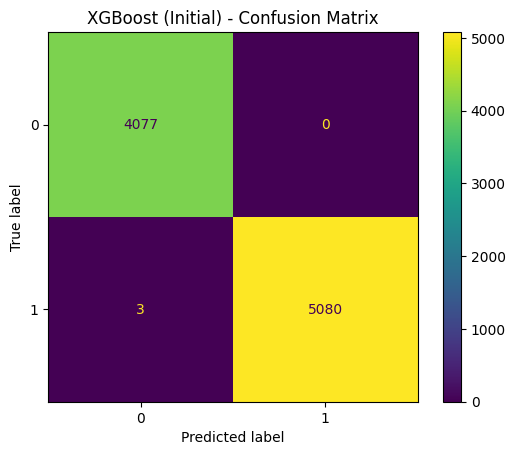

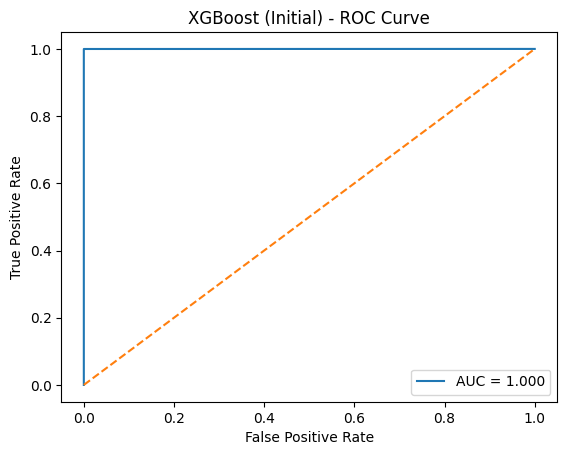

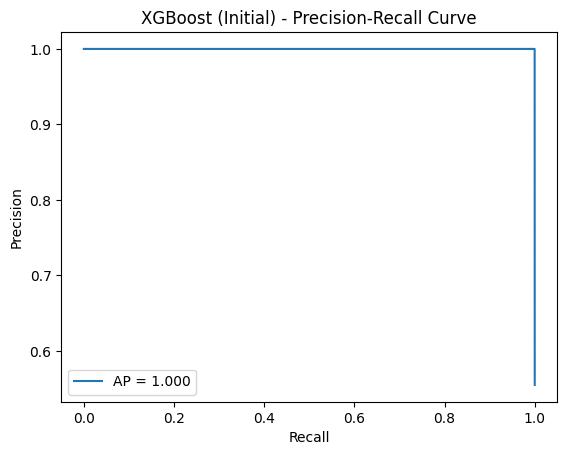

In [66]:
evaluate_model(
    xgb_model,
    X_val,
    y_val,
    "XGBoost (Initial)"
)

# Finding best parameters

In [65]:
xgb_param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [3, 5, 6, None],
    "classifier__learning_rate": [0.05, 0.1, 0.15]
}

grid_xgb = GridSearchCV(
    xgb_model,
    xgb_param_grid,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

grid_xgb.fit(X_train, y_train)

print("Best XGB Params:", grid_xgb.best_params_)

Best XGB Params: {'classifier__learning_rate': 0.15, 'classifier__max_depth': 6, 'classifier__n_estimators': 300}


XGBoost (Validation)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4077
           1       1.00      1.00      1.00      5083

    accuracy                           1.00      9160
   macro avg       1.00      1.00      1.00      9160
weighted avg       1.00      1.00      1.00      9160

ROC-AUC: 0.9999998552360471


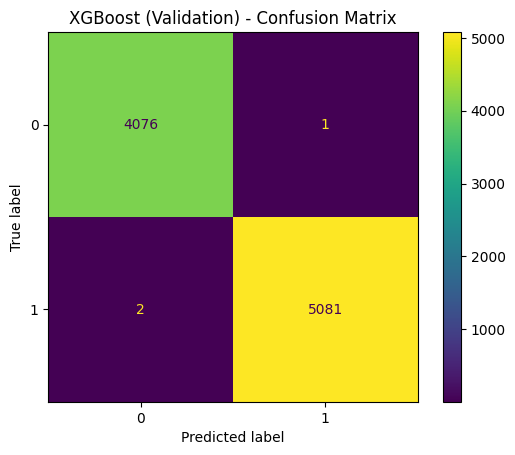

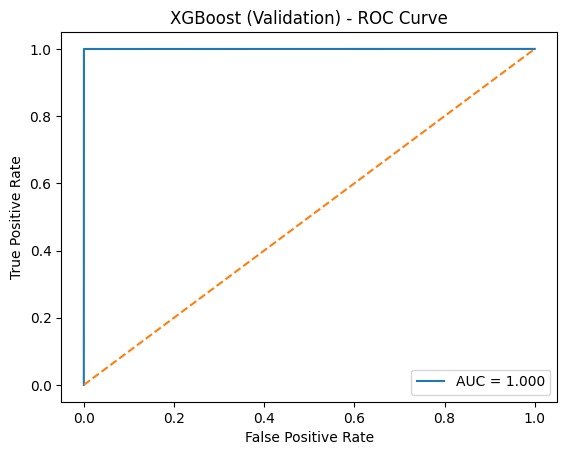

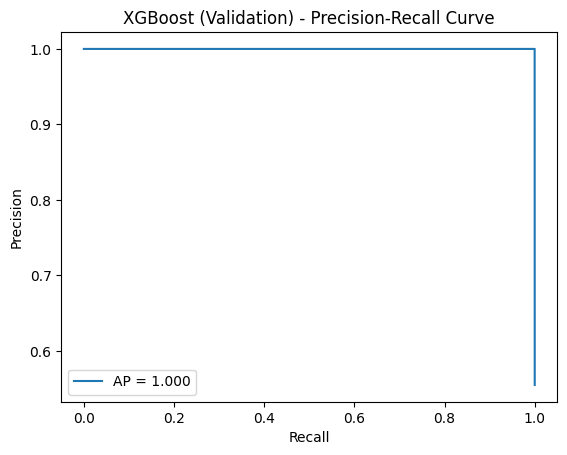

In [49]:
evaluate_model(
    grid_xgb.best_estimator_,
    X_val,
    y_val,
    "XGBoost (Validation)"
)

In [51]:
final_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.15,
        eval_metric="logloss",
        random_state=42
    ))
])

final_xgb.fit(X_train_final, y_train_final)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cap-diameter',
                                                   'stem-height',
                                                   'stem-width']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.15,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

XGBoost (Test)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4077
           1       1.00      1.00      1.00      5084

    accuracy                           1.00      9161
   macro avg       1.00      1.00      1.00      9161
weighted avg       1.00      1.00      1.00      9161

ROC-AUC: 0.999999710529043


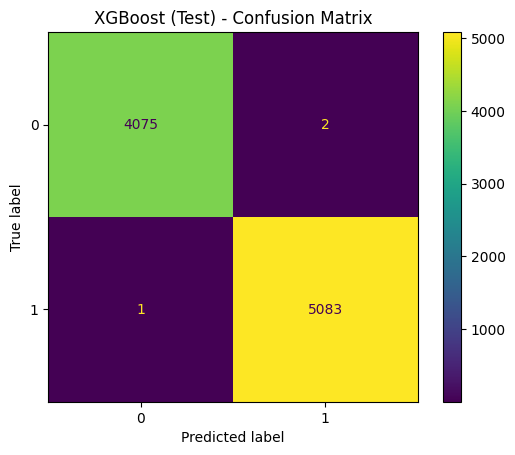

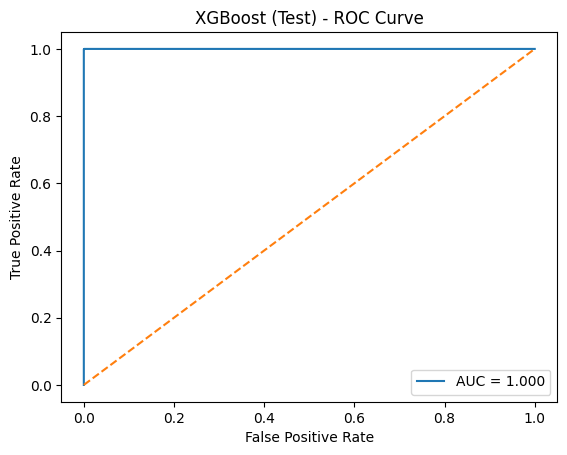

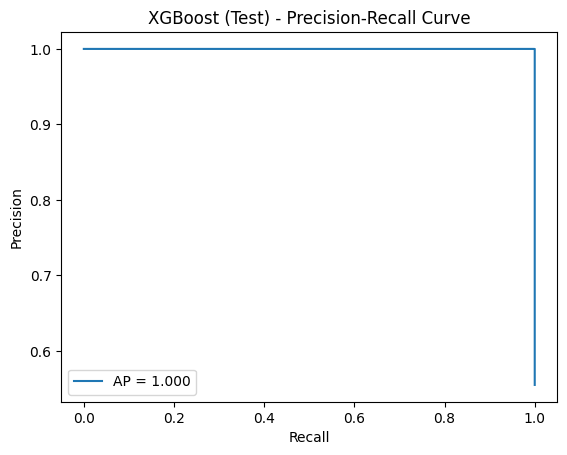

In [52]:
evaluate_model(
    final_xgb,
    X_test,
    y_test,
    "XGBoost (Test)"
)


In [53]:
joblib.dump(final_xgb, "best_mushroom_xgboost_model.pkl")

['best_mushroom_xgboost_model.pkl']

# feature importnace for Random Forest

In [54]:
feature_names = final_rf.named_steps["preprocessor"].get_feature_names_out()
importances = final_rf.named_steps["classifier"].feature_importances_

rf_importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

rf_importance_df.head(15)


,feature,importance
2,num__stem-width,0.113503
1,num__stem-height,0.080206
0,num__cap-diameter,0.072632
57,cat__stem-color_w,0.041593
44,cat__gill-color_w,0.028007
32,cat__gill-spacing_d,0.027626
31,cat__gill-spacing_c,0.027403
28,cat__gill-attachment_p,0.022921
23,cat__does-bruise-or-bleed_t,0.021685
24,cat__gill-attachment_a,0.021531


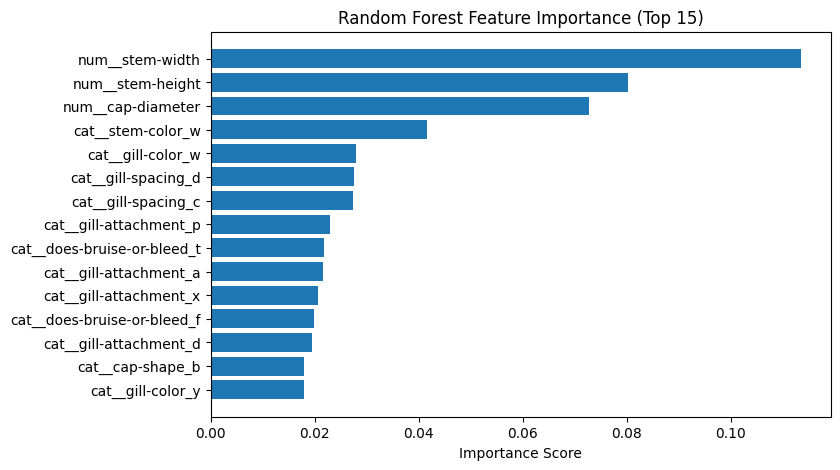

In [55]:
plt.figure(figsize=(8, 5))
plt.barh(
    rf_importance_df["feature"].head(15)[::-1],
    rf_importance_df["importance"].head(15)[::-1]
)
plt.title("Random Forest Feature Importance (Top 15)")
plt.xlabel("Importance Score")
plt.show()


In [56]:
coef = final_lr_pipeline.named_steps["classifier"].coef_[0]
feature_names = final_lr_pipeline.named_steps["preprocessor"].get_feature_names_out()

lr_importance_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef,
    "abs_coefficient": np.abs(coef)
}).sort_values(by="abs_coefficient", ascending=False)

lr_importance_df.head(15)


,feature,coefficient,abs_coefficient
68,cat__ring-type_z,1.536797,1.536797
28,cat__gill-attachment_p,-1.205537,1.205537
65,cat__ring-type_m,-1.153800,1.153800
49,cat__stem-color_g,-1.054032,1.054032
48,cat__stem-color_f,1.012531,1.012531
6,cat__cap-shape_o,0.918216,0.918216
18,cat__cap-color_r,0.900594,0.900594
57,cat__stem-color_w,-0.897638,0.897638
3,cat__cap-shape_b,0.728796,0.728796
11,cat__cap-color_e,0.696836,0.696836


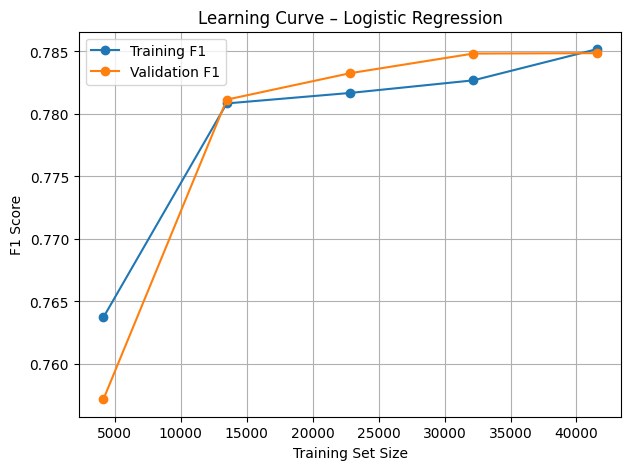

In [57]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    final_lr_pipeline,
    X_train_final,
    y_train_final,
    cv=5,
    scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, marker='o', label='Training F1')
plt.plot(train_sizes, val_mean, marker='o', label='Validation F1')
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.title("Learning Curve – Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

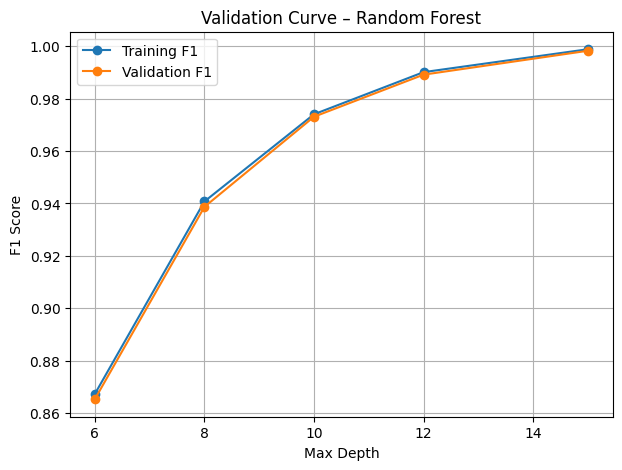

In [58]:
from sklearn.model_selection import validation_curve
import numpy as np
import matplotlib.pyplot as plt

param_range = [6, 8, 10, 12, 15]

train_scores, val_scores = validation_curve(
    final_rf,          
    X_train_final,              
    y_train_final,
    param_name="classifier__max_depth",  
    param_range=param_range,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(7,5))
plt.plot(param_range, train_mean, marker='o', label='Training F1')
plt.plot(param_range, val_mean, marker='o', label='Validation F1')
plt.xlabel("Max Depth")
plt.ylabel("F1 Score")
plt.title("Validation Curve – Random Forest")
plt.legend()
plt.grid(True)
plt.show()


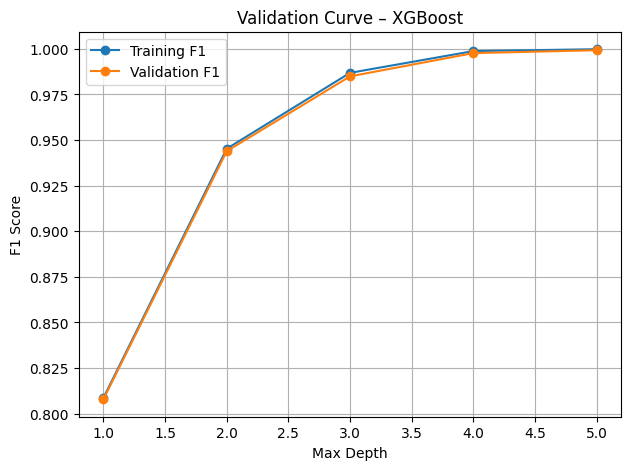

In [59]:
param_range = [1, 2, 3, 4, 5]

train_scores, val_scores = validation_curve(
    final_xgb,
    X_train_final,
    y_train_final,
    param_name="classifier__max_depth",
    param_range=param_range,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(7,5))
plt.plot(param_range, train_mean, marker='o', label='Training F1')
plt.plot(param_range, val_mean, marker='o', label='Validation F1')
plt.xlabel("Max Depth")
plt.ylabel("F1 Score")
plt.title("Validation Curve – XGBoost")
plt.legend()
plt.grid(True)

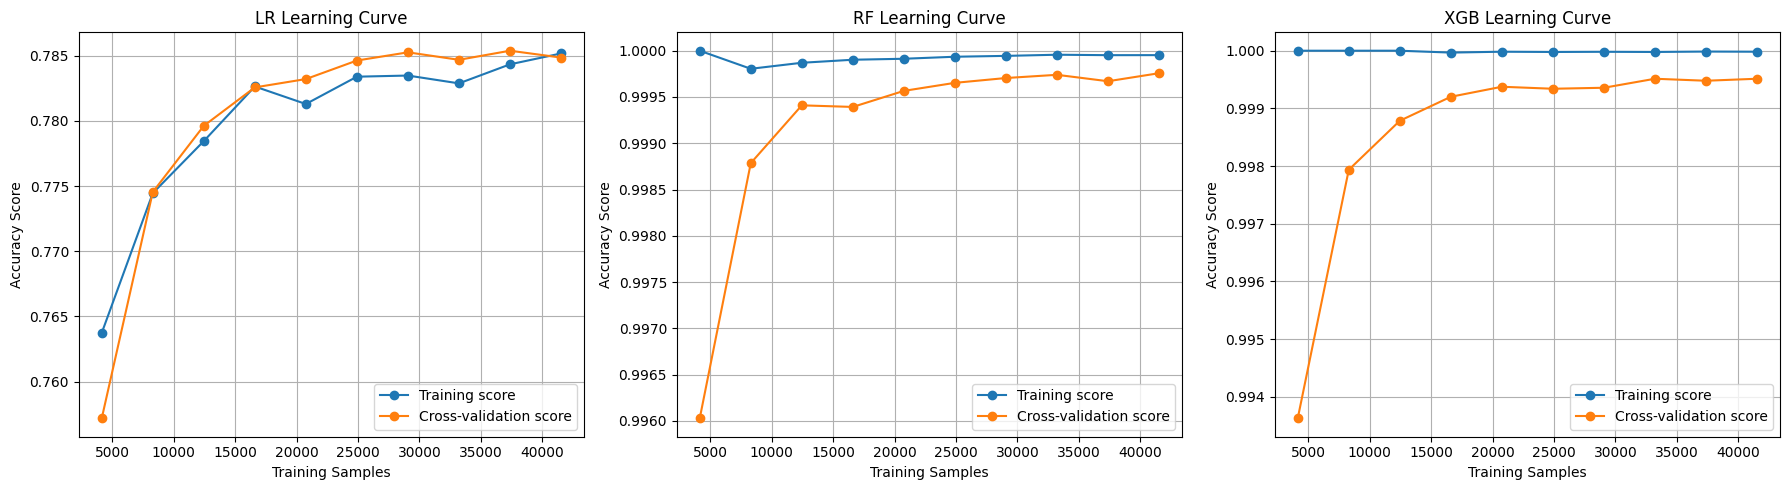

In [60]:
from sklearn.model_selection import learning_curve

def plot_all_learning_curves(models, X, y):
    plt.figure(figsize=(18, 5))
    
    for i, (name, model) in enumerate(models.items()):
        train_sizes, train_scores, test_scores = learning_curve(
            model, X, y, cv=5, n_jobs=-1, 
            train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1'
        )
        
        train_mean = np.mean(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)

        plt.subplot(1, 3, i+1)
        plt.plot(train_sizes, train_mean, 'o-', label="Training score")
        plt.plot(train_sizes, test_mean, 'o-', label="Cross-validation score")
        plt.title(f"{name} Learning Curve")
        plt.xlabel("Training Samples")
        plt.ylabel("F1 Score")
        plt.legend(loc="best")
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()


my_models = {"LR": final_lr_pipeline, "RF": final_rf, "XGB": final_xgb}
plot_all_learning_curves(my_models, X_train_final, y_train_final)

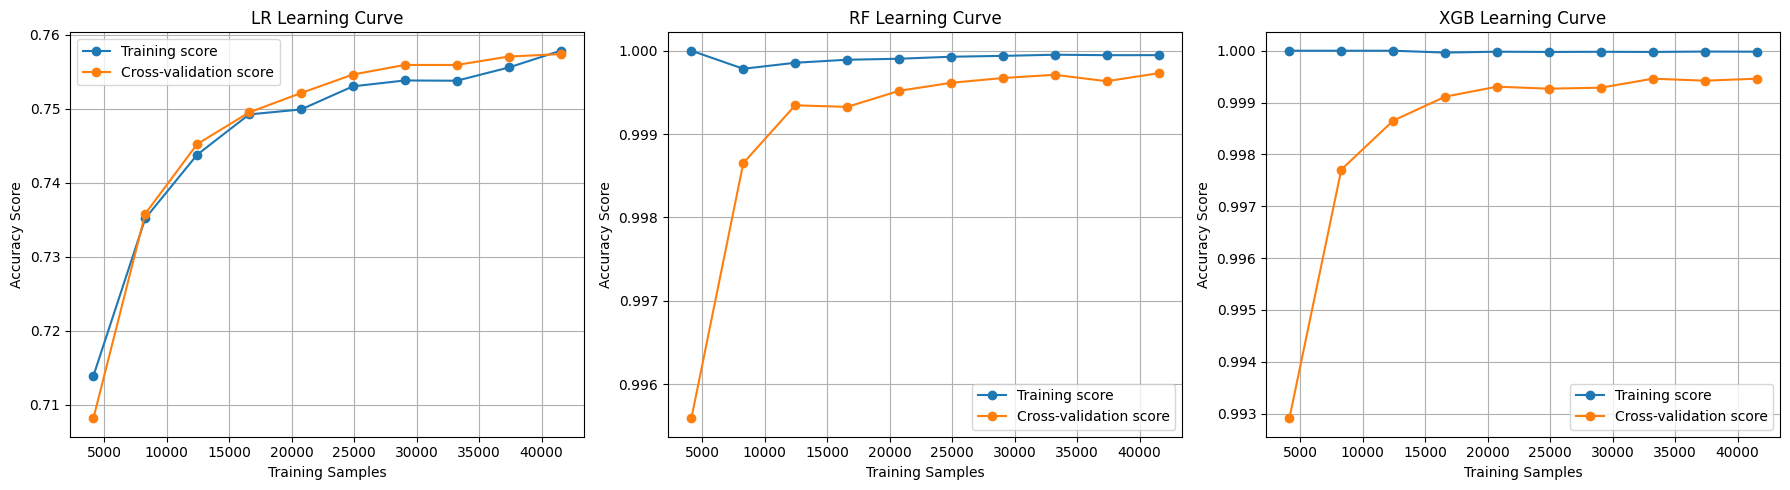

In [69]:
from sklearn.model_selection import learning_curve

def plot_all_learning_curves(models, X, y):
    plt.figure(figsize=(18, 5))
    
    for i, (name, model) in enumerate(models.items()):
        train_sizes, train_scores, test_scores = learning_curve(
            model, X, y, cv=5, n_jobs=-1, 
            train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
        )
        
        train_mean = np.mean(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)

        plt.subplot(1, 3, i+1)
        plt.plot(train_sizes, train_mean, 'o-', label="Training score")
        plt.plot(train_sizes, test_mean, 'o-', label="Cross-validation score")
        plt.title(f"{name} Learning Curve")
        plt.xlabel("Training Samples")
        plt.ylabel("Accuracy Score")
        plt.legend(loc="best")
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()


my_models = {"LR": final_lr_pipeline, "RF": final_rf, "XGB": final_xgb}
plot_all_learning_curves(my_models, X_train_final, y_train_final)